# YASA
This example script demonstrates how to use YASA to automatically detect sleep spindles.

Please make sure to install YASA first by following the procedure described at: https://github.com/raphaelvallat/yasa

In [1]:
import yasa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

## 1. Spindles detection
As an example, we load 30 seconds of N2 sleep on a single
channel central EEG data. The sampling rate is 200 Hz.

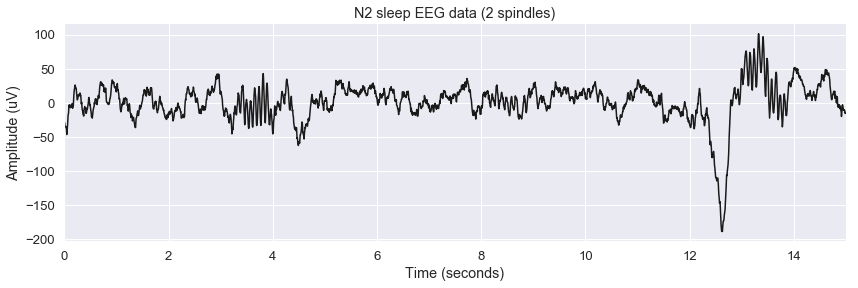

In [2]:
# Load data
data = np.loadtxt('data_N2_spindles_15sec_200Hz.txt')

# Define sampling frequency and time vector
sf = 200.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N2 sleep EEG data (2 spindles)')
sns.despine()

We can clearly see that there are two clean spindles on this 15-seconds epoch. The first one starting at around 3.5 seconds and the second one starting around 13 seconds.

Let's detect these spindles using yasa:

In [3]:
sp = yasa.spindles_detect(data, sf)
sp

,Start,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
0,3.35,4.03,0.68,81.497704,20.172379,2.716910,0.547649,12.782565,8.0,0.666667
1,13.16,13.86,0.70,99.323421,24.197919,2.883098,0.310223,12.267465,8.0,0.352113


The algorithm successfully identified the two spindles. The output of yasa `spindles_detect` function is a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) where each row is a unique spindle and each column a parameter describing this spindle. The different parameters are described in the documentation:

In [4]:
yasa.spindles_detect?

Signature: yasa.spindles_detect(data, sf, freq_sp=(11, 16), duration=(0.4, 2.5), freq_broad=(1, 30), min_distance=500, thresh={'rel_pow': 0.2, 'corr': 0.65, 'rms': 10})
Docstring:
Spindles detection using a custom algorithm based on
Lacourse et al. 2018.

Parameters
----------
data : array_like
    Single-channel data
sf : float
    Sampling frequency of the data in Hz.
freq_sp : tuple or list
    Spindles frequency range. Default is 11 to 16 Hz.
freq_broad : tuple or list
    Broad band frequency of interest.
    Default is 1 to 30 Hz.
min_distance : int
    If two spindles are closer than `min_distance` (in ms), they are
    merged into a single spindles. Default is 500 ms.
thresh : dict
    Detection thresholds::

        'rel_pow' : Relative power (= power ratio freq_sp / freq_broad).
        'corr' : Pearson correlation coefficient.
        'rms' : Root mean square

Returns
-------
sp_params : pd.DataFrame
    Pandas DataFrame::

        'Start' : Start time of each detected spind

### 1.1 Plot an overlay of our detected spindles
First we need to create a boolean array of the same size of data indicating for each sample if this sample is part of a spindles or not. This is done using the `get_bool_vector` function.

In [5]:
# Let's get a bool vector indicating for each sample
bool_spindles = yasa.get_bool_vector(data, sf, sp)

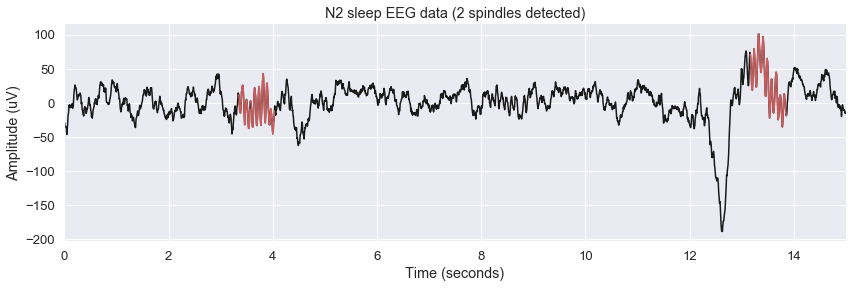

In [6]:
# Now let's plot
spindles_highlight = data * bool_spindles
spindles_highlight[spindles_highlight == 0] = np.nan

plt.figure(figsize=(14, 4))
plt.plot(times, data, 'k')
plt.plot(times, spindles_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N2 sleep EEG data (2 spindles detected)')
sns.despine()
# plt.savefig('detection.png', dpi=300, bbox_inches='tight')

## 2. Behind the black box: the YASA algorithm step-by-step

The YASA algorithm is largely inspired by the A7 algorithm described in [Lacourse et al. 2018](https://doi.org/10.1016/j.jneumeth.2018.08.014):

> Lacourse, K., Delfrate, J., Beaudry, J., Peppard, P., Warby, S.C., 2018. A sleep spindle detection algorithm that emulates human expert spindle scoring. *J. Neurosci. Methods*. https://doi.org/10.1016/j.jneumeth.2018.08.014

The main idea of the algorithm is to compute different thresholds from the broadband-filtered signal (1 to 30Hz, $EEG_{bf}$) and the sigma-filtered signal (11 to 16 Hz, $EEG_{\sigma}$).

**There are some notable exceptions between YASA and the A7 algorithm:**
1. YASA uses 3 different thresholds (relative $\sigma$ power, [root mean square](https://en.wikipedia.org/wiki/Root_mean_square) and correlation). The A7 algorithm uses 4 thresholds (absolute and relative $\sigma$ power, covariance and correlation).
2. The windowed detection signals are resampled to the original time vector of the data using cubic interpolation, thus resulting in a pointwise detection signal (= one value at every sample). The time resolution of YASA is therefore higher than the A7 algorithm. This allows for more precision to detect the beginning and end of the events (typically, A7 = 100 ms and YASA = 10 ms).
3. The relative power in the sigma band is computed using a Short-Term Fourier Transform. The relative sigma power is not z-scored.
4. The median frequency of the spindles is computed using the instantaneous frequencies extracted from the analytic Hilbert signal.
5. The median power of the spindles is computed using the instantaneous power extracted from the analytic Hilbert signal.
6. YASA computes some additional spindles properties, such as the symmetry index and number of oscillations. These metrics are inspired from [Purcell et al. 2017](https://www.nature.com/articles/ncomms15930).
7. The minimum duration of spindle is 400 ms (300 ms in the A7 algorithm).

### Preprocessing

1. The signal is downsampled to 100 Hz if the original sampling frequency is greater or equal than 200 Hz. This is mainly to speed up subsequent computations. Note that this downsampling has no or very little effect on the spindles detection.
2. The raw signal is bandpass filtered to the broadband frequency range defined in the (optional) parameter `freq_broad`. The default is to use a FIR filter from 1 to 30 Hz. The filter is done using the MNE built-in [filter_data](https://martinos.org/mne/stable/generated/mne.filter.filter_data.html) function. The resulting, filtered, signal is $EEG_{bf}$.

In [7]:
from mne.filter import resample, filter_data

# 1 - Downsample to 100 Hz
data = resample(data, up=0.5, down=1., verbose=False)
sf = 100
times = np.arange(data.size) / sf

# 2 - Braodband bandpass filter
freq_broad = (1, 30)
data = filter_data(data, sf, freq_broad[0], freq_broad[1], method='fir',verbose=0)

## Threshold 1: Relative power in the sigma band

The first detection signal is the power in the sigma frequency range (11-16 Hz) relative to the total power in the broadband frequency (1-30 Hz). This is calculated using a [Short-Term Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (STFT) on consecutive epochs of 2 seconds and with an overlap of 100 ms. The first threshold is exceeded whenever a sample has a relative power in the sigma frequency range greater than or equal to 0.2. In other words, it means that 20% of the signal's total power must be contained within the sigma frequency range.

In the code below, we first compute the STFT, plot the resulting spectrogram (time on the x-axis, frequency on the y-axis) and then extract the relative power in the sigma frequency range.

#### More about the STFT

Because our STFT has a window of 2 seconds, it means that our frequency resolution is $1 / 2 = 0.5$ Hz. In other words, our frequency vector is *[1, 1.5, 2, ..., 29, 29.5, 30]* Hz. The power in the sigma frequency range is simply the sum, at each time point, of the power values at $f_{\sigma}=$*[11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16]* Hz.

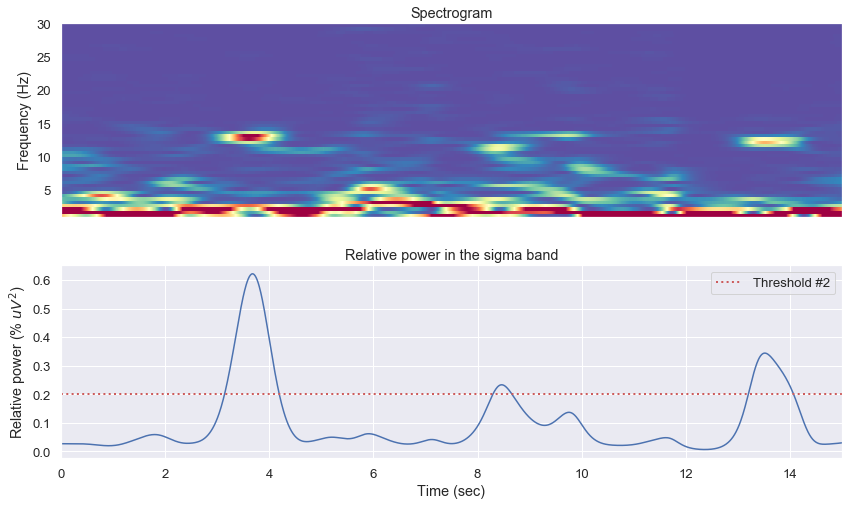

In [8]:
# Compute the pointwise relative power using STFT and cubic interpolation
f, t, Sxx = yasa.main.stft_power(data, sf, window=2, step=.1, band=freq_broad, norm=True, interp=True)
idx_sigma = np.logical_and(f >= 11, f <= 16)
rel_pow = Sxx[idx_sigma].sum(0)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
plt.subplots_adjust(hspace=.25)
im = ax1.pcolormesh(t, f, Sxx, cmap='Spectral_r', vmax=0.2)
ax1.set_title('Spectrogram')
ax1.set_ylabel('Frequency (Hz)')
ax2.plot(t, rel_pow)
ax2.set_ylabel('Relative power (% $uV^2$)')
ax2.set_xlim(t[0], t[-1])
ax2.set_xlabel('Time (sec)')
ax2.axhline(0.20, ls=':', lw=2, color='indianred', label='Threshold #2')
plt.legend()
_ = ax2.set_title('Relative power in the sigma band')

In [9]:
%timeit yasa.main.stft_power(data, sf, window=2, step=.1, band=freq_broad, norm=True)

2.91 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Threshold 2: Moving correlation

For the two remaining thresholds, we are going to need the sigma-filtered signal ($EEG_{\sigma}$). Here again, we use the MNE built-in [FIR filter](https://martinos.org/mne/stable/generated/mne.filter.filter_data.html).

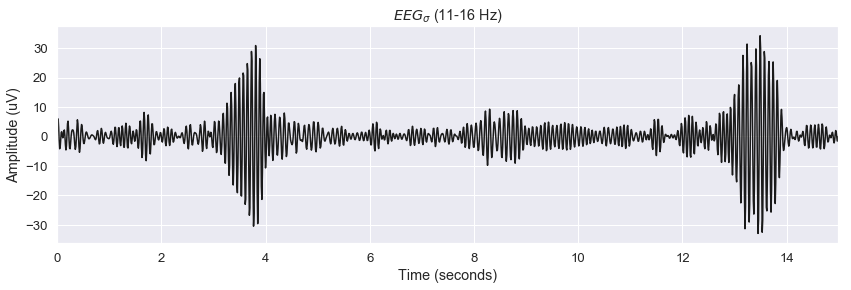

In [10]:
freq_sp = (11, 16)
trans = 1
data_sigma = filter_data(data, sf, freq_sp[0] + trans, freq_sp[1] - trans, method='fir', verbose=0)

# Plot the filtered signal
plt.figure(figsize=(14, 4))
plt.plot(times, data_sigma, 'k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.title('$EEG_{\sigma}$ (11-16 Hz)')
_ = plt.xlim(0, times[-1])

Our second detection signal is calculated by taking, with a moving sliding window of 300 ms and a step of 100 ms, the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between and $EEG_{\bf}$ and $EEG_{\sigma}$. According to [Lacourse et al. 2018](http://dx.doi.org/10.1016/j.jneumeth.2018.08.014):

> The current spindle detector design is unique because it uses a correlation filter between the EEG signal filtered in the sigma band and the raw EEG signal itself. The proposed design is therefore biased to detect spindles that are visible on the raw EEG signal by requiring a high correlation between raw EEG signal and the filtered sigma burst (the pattern that represents a spindle).

Once again, the value are interpolated using cubic interpolation to obtain one value per each time point. The second threshold is exceeded whenever a sample has a correlation value >= 0.65.

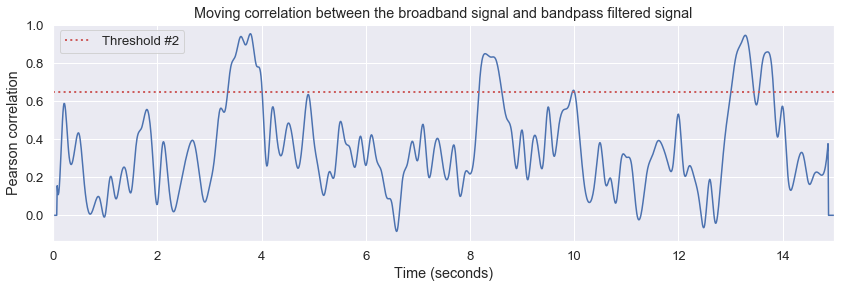

In [11]:
t, mcorr = yasa.main.moving_transform(data_sigma, data, sf, window=.3, step=.1, method='corr', interp=True)

plt.figure(figsize=(14, 4))
plt.plot(times, mcorr)
plt.xlabel('Time (seconds)')
plt.ylabel('Pearson correlation')
plt.axhline(0.65, ls=':', lw=2, color='indianred', label='Threshold #2')
plt.legend()
plt.title('Moving correlation between the broadband signal and bandpass filtered signal')
_ = plt.xlim(0, times[-1])

#### Execution time

For 30 seconds of data, this function will compute 300 correlation coefficients. To reduce the computation time, YASA uses a custom, [Numba-accelerated](https://numba.pydata.org/), function to compute the correlation coefficients. This is roughly 10-30 times faster than using the default [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) function. 

In [12]:
# Total duration of the moving correlation
%timeit -n 100 yasa.main.moving_transform(data_sigma, data, sf, window=.3, step=.1, method='corr', interp=True)

941 µs ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Threshold 3: Moving RMS

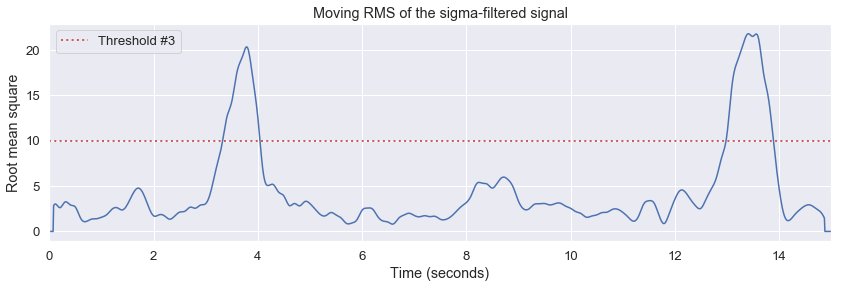

In [13]:
t, mrms = yasa.main.moving_transform(data_sigma, data, sf, window=.3, step=.1, method='rms', interp=True)

plt.figure(figsize=(14, 4))
plt.plot(times, mrms)
plt.xlabel('Time (seconds)')
plt.ylabel('Root mean square')
plt.axhline(10, ls=':', lw=2, color='indianred', label='Threshold #3')
plt.legend()
plt.title('Moving RMS of the sigma-filtered signal')
_ = plt.xlim(0, times[-1])

### Decision function
Every sample of the data that validate all 3 thresholds is considered as a potential sleep spindle. However, the detection using the three thresholds tends to underestimate the real duration of the spindle. To overcome this, we compute a soft threshold by smoothing the `idx_sum` vector using a 100 ms window. We then find indices that are strictly greater than 2. In other words, we find
the *true* beginning and *true* end of the events by finding the indices at which two out of the three treshold were crossed.

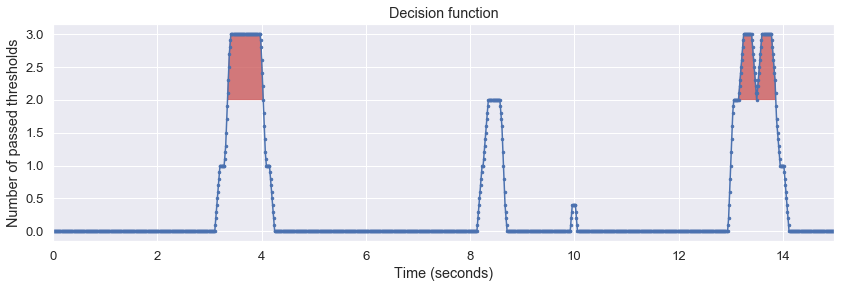

In [14]:
idx_rel_pow = (rel_pow >= 0.2).astype(int)
idx_mcorr = (mcorr >= 0.65).astype(int)
idx_mrms = (mrms >= 10).astype(int)
idx_sum = (idx_rel_pow + idx_mcorr + idx_mrms).astype(int)

w = int(0.1 * sf)
idx_sum = np.convolve(idx_sum, np.ones(w) / w, mode='same')

plt.figure(figsize=(14, 4))
plt.plot(times, idx_sum, '.-', markersize=5)
plt.fill_between(times, 2, idx_sum, where=idx_sum > 2, color='indianred', alpha=.8)
plt.xlabel('Time (seconds)')
plt.ylabel('Number of passed thresholds')
plt.title('Decision function')
_ = plt.xlim(0, times[-1])

### Morphological criteria
1. Finally, spindles that are too close to each other (less than 500 ms) are merged together
2. Spindles that are either too short or too long are removed
3. For each remaining spindle, a bunch of parameters are extracted.
    - Start and end time in seconds
    - Duration (seconds)
    - Amplitude ($\mu V$)
    - Root mean square ($\mu V$)
    - Median absolute power ($\log_{10} \mu V^2$)
    - Median relative power (from 0 to 1, % $\mu V^2$)
    - Median frequency (Hz, extracted using the analytical signal of an Hilbert transform)
    - Number of oscillations
    - Symmetry (indicates where is the most prominent peak on a 0 to 1 vector where 0 is the beginning of the spindles and 1 the end. Ideally it should be around 0.5)

In [15]:
yasa.spindles_detect(data, sf)

,Start,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
0,3.35,4.03,0.68,81.203310,20.112906,2.716408,0.546879,12.783054,8.0,0.666667
1,13.14,13.86,0.72,99.169181,23.782660,2.880061,0.318590,12.299577,9.0,0.369863


In [16]:
%timeit yasa.spindles_detect(data, sf)

10.8 ms ± 482 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Safety check

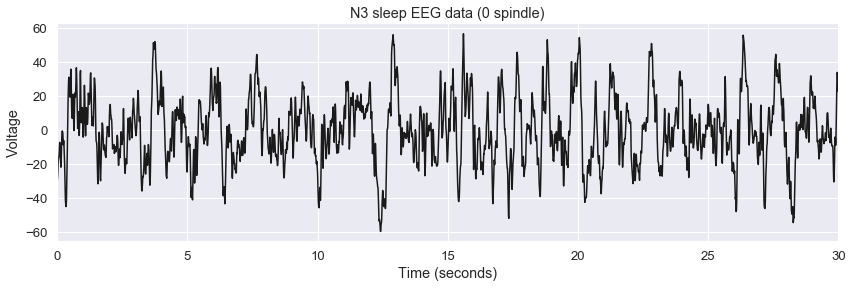

In [17]:
data_no_sp = np.loadtxt('data_N3_no-spindles_30sec_100Hz.txt')
sf_no_sp = 100
times_no_sp = np.arange(data_no_sp.size) / sf_no_sp

plt.figure(figsize=(14, 4))
plt.plot(times_no_sp, data_no_sp, 'k')
plt.xlim(0, times_no_sp.max())
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([times_no_sp.min(), times_no_sp.max()])
plt.title('N3 sleep EEG data (0 spindle)')
sns.despine()

In [18]:
sp_params = yasa.spindles_detect(data_no_sp, sf_no_sp)
sp_params

No spindle were found in data. Returning None.
